In [1]:

from sklearnex import patch_sklearn
from daal4py.oneapi import sycl_context
# patch_sklearn()

%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.regression import *
from hossam.plot import *
from hossam.tensor import *
from hossam.analysis import *
from hossam.classification import *
from pandas import merge, read_excel, pivot_table, melt, to_datetime, to_timedelta, DateOffset, Timestamp, Period, Series
import numpy as np
import re
import seaborn as sns

# 로지스틱 회귀 통계 모형
from statsmodels.api import Logit, add_constant
# 확률밀도함수
from scipy.stats import norm
from datetime import datetime

[scatterd] >WARNING> From c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



## #01 더미화 데이터 사용 

In [19]:
data = read_excel('변수정리데이터.xlsx')
data.drop(columns=['Unnamed: 0'], inplace=True)
data.info()
# data.loc[:,tmp_column] = data.loc[:,tmp_column].astype('category')
# data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6309 entries, 0 to 6308
Data columns (total 55 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CRR         6309 non-null   float64
 1   F1          6309 non-null   int64  
 2   Pt매출        6309 non-null   int64  
 3   개월수         6309 non-null   int64  
 4   거래횟수        6309 non-null   int64  
 5   결제시점        6309 non-null   int64  
 6   골프레슨매출      6309 non-null   int64  
 7   광고          6309 non-null   int64  
 8   라카매출        6309 non-null   int64  
 9   미수액         6309 non-null   int64  
 10  분실          6309 non-null   int64  
 11  양도비매출       6309 non-null   int64  
 12  의류매출        6309 non-null   int64  
 13  일일입장        6309 non-null   int64  
 14  출석          6309 non-null   float64
 15  필라테스매출      6309 non-null   int64  
 16  헬스매출        6309 non-null   int64  
 17  category_1  6309 non-null   int64  
 18  category_2  6309 non-null   int64  
 19  category_3  6309 non-null  

In [ ]:
# 이탈여부_2 는 이탈여부를 알 수 없는 최근 회원의 경우이므로 테스트용으로 사용할 예정
test_data = data[data['이탈여부_2']==1] 
train_data = data[data['이탈여부_2']==0]

### 데이터 샘플링 방법1

In [14]:
def split_data(data, frac):
  train_df = data.sample(axis=0, frac=frac)
  test_df = data[data.index.isin(train_df.index)==False]
  return train_df, test_df

In [28]:
pos_df = train_data[train_data['이탈여부_1']==1]
neg_df = train_data[train_data['이탈여부_1']==0]

In [29]:
neg_df.shape, pos_df.shape

((1521, 55), (3577, 55))

In [30]:
train_df1, test_df1 = split_data(pos_df, 0.7)
test_df1, valid_df1 = split_data(test_df1, 0.7)
train_df0, test_df0 = split_data(neg_df, 0.7)
test_df0, valid_df0 = split_data(test_df0, 0.7)

In [31]:
valid_df1

,CRR,F1,Pt매출,개월수,거래횟수,결제시점,골프레슨매출,광고,라카매출,미수액,...,트레이너_23,Fc 성별_1,Fc 성별_2,단체회원_1,분기_1,분기_2,분기_3,양도_1,이탈여부_1,이탈여부_2
5,-10.456853,5,0,12,1,0,0,0,100000,0,...,0,0,0,0,0,1,0,0,1,0
40,-10.456853,40,0,7,2,6,660000,0,0,0,...,0,1,0,0,0,1,0,0,1,0
43,-10.456853,43,0,-6,2,0,0,0,-120000,0,...,0,0,1,1,0,1,0,0,1,0
63,-10.456853,63,0,-10,1,0,0,0,-30000,0,...,0,0,0,0,0,1,0,0,1,0
67,-10.456853,67,0,12,2,4,0,0,50000,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6103,-3.347639,6103,0,12,2,-2,0,0,240000,0,...,0,1,0,1,0,0,1,0,1,0
6154,-3.347639,6154,0,1,1,0,0,0,10000,0,...,0,0,1,0,0,0,1,0,1,0
6188,-3.706395,6188,0,-8,4,4,0,0,-100000,0,...,0,1,0,0,1,0,0,0,1,0
6189,-3.706395,6189,0,-7,5,-3,0,0,-120000,0,...,0,1,0,0,1,0,0,0,1,0


In [33]:
train_df = concat([train_df1, train_df0])
valid_df = concat([valid_df1, valid_df0])
test_df = concat([test_df1, test_df0])

train_df.shape, valid_df.shape, test_df.shape

((3569, 55), (459, 55), (1070, 55))

In [34]:
print(train_df.groupby('이탈여부_1')['이탈여부_1'].count())
print(test_df.groupby('이탈여부_1')['이탈여부_1'].count())
print(valid_df.groupby('이탈여부_1')['이탈여부_1'].count())

이탈여부_1
0    1065
1    2504
Name: 이탈여부_1, dtype: int64
이탈여부_1
0    319
1    751
Name: 이탈여부_1, dtype: int64
이탈여부_1
0    137
1    322
Name: 이탈여부_1, dtype: int64


### 데이터 학습

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [36]:
class cust_dataset(Dataset):
  def __init__(self, data):
    self.data = data
    self.X = torch.tensor(self.data.drop('이탈여부_1', axis=1).to_numpy(), dtype=torch.float)
    self.y = torch.tensor(self.data['이탈여부_1'].to_numpy(), dtype=torch.float).reshape(-1,1)

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self,i):
    return self.X[i], self.y[i]

In [37]:

print(train_df.dtypes)

CRR           float64
F1              int64
Pt매출            int64
개월수             int64
거래횟수            int64
결제시점            int64
골프레슨매출          int64
광고              int64
라카매출            int64
미수액             int64
분실              int64
양도비매출           int64
의류매출            int64
일일입장            int64
출석            float64
필라테스매출          int64
헬스매출            int64
category_1      int64
category_2      int64
category_3      int64
category_4      int64
category_5      int64
category_6      int64
트레이너_1          int64
트레이너_2          int64
트레이너_3          int64
트레이너_4          int64
트레이너_5          int64
트레이너_6          int64
트레이너_7          int64
트레이너_8          int64
트레이너_9          int64
트레이너_10         int64
트레이너_11         int64
트레이너_12         int64
트레이너_13         int64
트레이너_14         int64
트레이너_15         int64
트레이너_16         int64
트레이너_17         int64
트레이너_18         int64
트레이너_19         int64
트레이너_20         int64
트레이너_21         int64
트레이너_22         int64
트레이너_23   

In [38]:
train_dataset = cust_dataset(train_df)
validation_dataset = cust_dataset(valid_df)
test_dataset = cust_dataset(test_df)

In [39]:
train_dataset.__len__(), validation_dataset.__len__(), test_dataset.__len__()

(3569, 459, 1070)

In [40]:
train_dataset.__getitem__(0)

(tensor([2.3336e+00, 6.0130e+03, 0.0000e+00, 6.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+05, 0.0000e+00, 0.0000e+00, 5.0000e+04,
         0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 9.9000e+05, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00]),
 tensor([1.]))

In [23]:
from torch.utils.data.sampler import WeightedRandomSampler

def class_imbalance_sampler(labels):
    class_count = torch.bincount(labels.squeeze())
    class_weighting = 1. / class_count
    sample_weights = class_weighting[labels]
    sampler = WeightedRandomSampler(sample_weights, len(labels))
    return sampler

In [42]:
labels = train_dataset.y.int().squeeze()

In [43]:
class_count = torch.bincount(torch.tensor(train_df['이탈여부_1'].to_numpy()))
class_weighting = 1. / class_count

In [44]:
sample_weights = class_weighting[labels]
print(sample_weights)
print(sample_weights.size())

tensor([0.0004, 0.0004, 0.0004,  ..., 0.0009, 0.0009, 0.0009])
torch.Size([3569])


In [45]:
train_sampler = class_imbalance_sampler(train_dataset.y.int().squeeze())
train_sampler.num_samples

3569

In [46]:
train_dataloader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler,drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=64,  shuffle=False,drop_last=True) # 평가시에는 Sampler 사용X
test_dataloader = DataLoader(test_dataset, batch_size=64,  shuffle=False,drop_last=True) # 평가시에는 Sampler 사용X

In [47]:
class ChurnNet(nn.Module):
    def __init__(self):
        super(ChurnNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(54, 128),  # 입력 크기를 변경
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [48]:
model = ChurnNet()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # torch는 L2만 있음
criterion = nn.BCELoss()

In [49]:
# 학습 함수
def train(model, criterion, optimizer, loader):
    model.train()
    for data, target in loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# 평가 함수
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            total_loss += criterion(output, target).item() 
            pred = torch.tensor(output>0.5) # binary 문제이므로 값은 0과 1 사이의 값일 것. Threshold 는 이에 맞게 지정
            correct += pred.eq(target.view_as(pred)).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def train_test(model, criterion, optimizer, train_loader, test_loader, epoch):

  train_losses = [] # loss를 받을 때의 list를 만들어줌.
  test_losses = []
  train_acces = []
  test_acces = []
  # 학습 및 평가
  for epoch in range(epoch):
      train(model, criterion, optimizer, train_loader)
      train_loss, train_acc = evaluate(model, train_loader)
      test_loss, test_acc = evaluate(model, test_loader)
      train_losses.append(train_loss)
      test_losses.append(test_loss)
      train_acces.append(train_acc)
      test_acces.append(test_acc)
      print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Valid Acc: {test_acc:.4f}')

  return train_losses, test_losses, train_acces, test_acces

In [26]:
def plot_acc(train_acces, test_acces):
  plt.plot(train_acces, label='train_acc')
  plt.plot(test_acces, label='valid_acc')
  plt.xlabel('Epoch')
  plt.ylabel('acc')
  plt.title('Training and Test acc')
  plt.legend()
  plt.show()

In [27]:
def plot_loss(train_losses, test_losses):
  plt.plot(train_losses, label='Training Loss')
  plt.plot(test_losses, label='Valid Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Test Loss')
  plt.legend()
  plt.show()

Epoch 1, Train Loss: 0.3737, Train Acc: 0.4850, Test Loss: 0.5177, Valid Acc: 0.6427
Epoch 2, Train Loss: 0.3789, Train Acc: 0.4791, Test Loss: 0.4260, Valid Acc: 0.7015
Epoch 3, Train Loss: 0.3626, Train Acc: 0.5013, Test Loss: 0.4260, Valid Acc: 0.7015
Epoch 4, Train Loss: 0.3667, Train Acc: 0.4973, Test Loss: 0.4261, Valid Acc: 0.7015
Epoch 5, Train Loss: 0.3905, Train Acc: 0.4646, Test Loss: 0.4260, Valid Acc: 0.7015
Epoch 6, Train Loss: 0.3543, Train Acc: 0.5111, Test Loss: 0.7220, Valid Acc: 0.5120
Epoch 7, Train Loss: 0.3434, Train Acc: 0.5220, Test Loss: 0.7186, Valid Acc: 0.5142
Epoch 8, Train Loss: 0.3733, Train Acc: 0.4867, Test Loss: 0.4258, Valid Acc: 0.7015
Epoch 9, Train Loss: 0.3668, Train Acc: 0.4951, Test Loss: 0.4259, Valid Acc: 0.7015
Epoch 10, Train Loss: 0.3803, Train Acc: 0.4802, Test Loss: 0.4259, Valid Acc: 0.7015
Epoch 11, Train Loss: 0.3676, Train Acc: 0.4943, Test Loss: 0.4258, Valid Acc: 0.7015
Epoch 12, Train Loss: 0.3841, Train Acc: 0.4730, Test Loss: 0.4

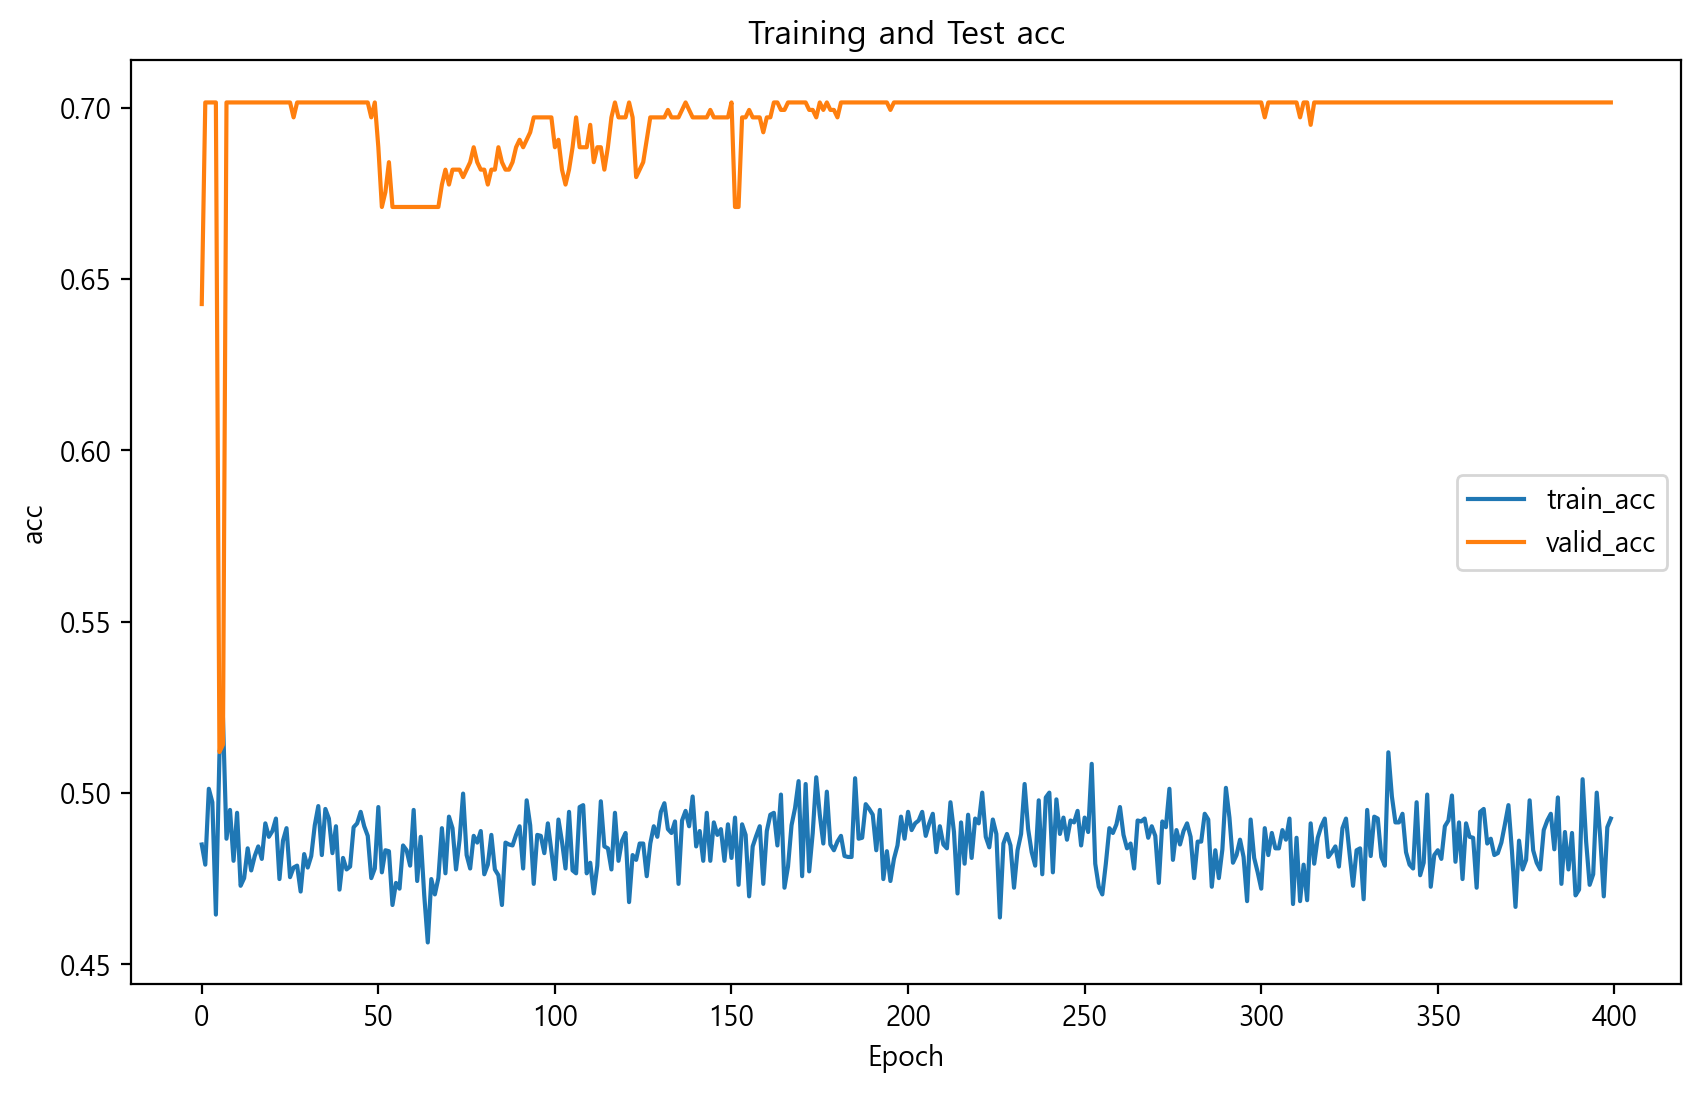

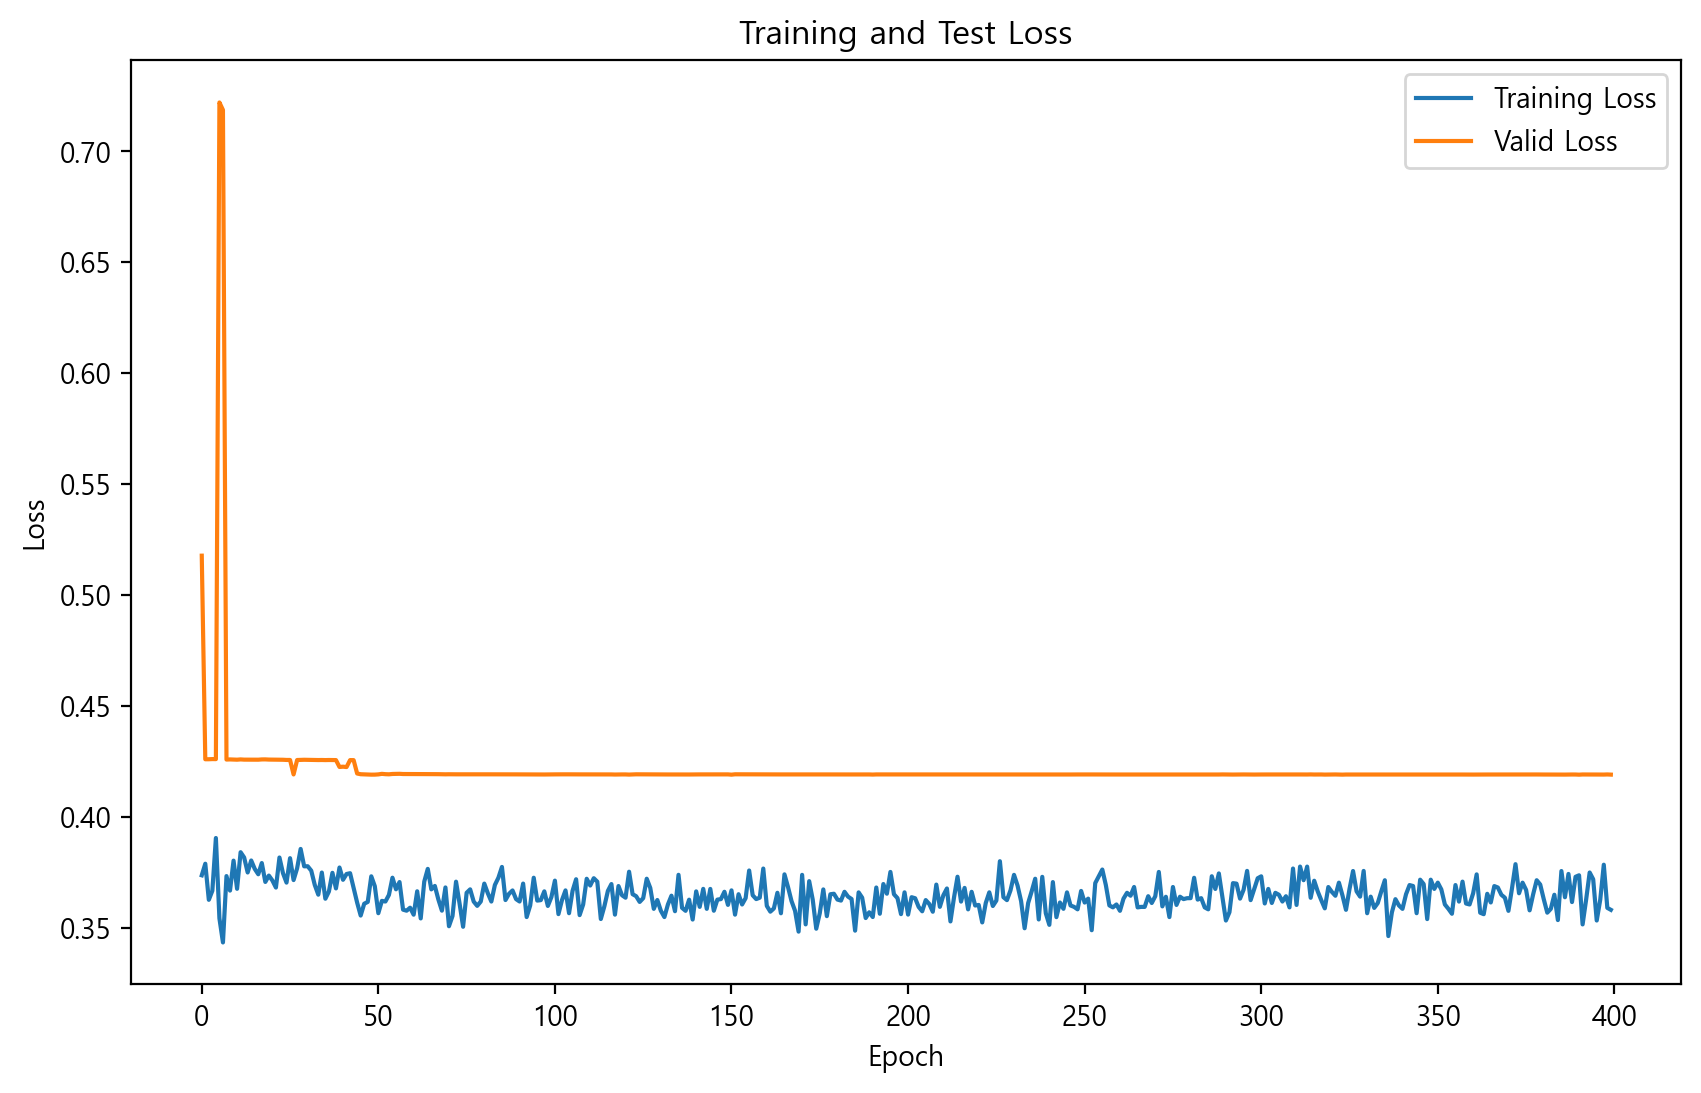

In [52]:
epoch = 400

train_losses, test_losses, train_acces, test_acces = train_test(model, criterion, optimizer, train_dataloader, validation_dataloader, epoch)
plot_acc(train_acces, test_acces)
plot_loss(train_losses, test_losses)

## #02 타겟인코딩 데이터 사용

In [4]:
data = read_excel('변수정리데이터_타겟인코딩.xlsx')
data.drop(columns=['Unnamed: 0'], inplace=True)
data.info()
# data.loc[:,tmp_column] = data.loc[:,tmp_column].astype('category')
# data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6309 entries, 0 to 6308
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   category          6309 non-null   int64  
 1   트레이너              6309 non-null   int64  
 2   CRR               6309 non-null   float64
 3   F1                6309 non-null   int64  
 4   Fc 성별             6309 non-null   int64  
 5   Pt매출              6309 non-null   int64  
 6   개월수               6309 non-null   int64  
 7   거래횟수              6309 non-null   int64  
 8   결제시점              6309 non-null   int64  
 9   골프레슨매출            6309 non-null   int64  
 10  광고                6309 non-null   int64  
 11  단체회원              6309 non-null   int64  
 12  라카매출              6309 non-null   int64  
 13  미수액               6309 non-null   int64  
 14  분기                6309 non-null   int64  
 15  분실                6309 non-null   int64  
 16  양도                6309 non-null   int64  


In [9]:
# 이탈여부 2 는 이탈여부를 알 수 없는 최근 회원의 경우이므로 테스트용으로 사용할 예정
test_data = data[data['이탈여부']==2]
train_data = data[data['이탈여부']!=2]

### 데이터 샘플링

In [12]:
pos_df = train_data[train_data['이탈여부']==1]
neg_df = train_data[train_data['이탈여부']==0]
neg_df.shape, pos_df.shape

((1521, 30), (3577, 30))

In [15]:
train_df1, test_df1 = split_data(pos_df, 0.7)
test_df1, valid_df1 = split_data(test_df1, 0.7)
train_df0, test_df0 = split_data(neg_df, 0.7)
test_df0, valid_df0 = split_data(test_df0, 0.7)
valid_df1

,category,트레이너,CRR,F1,Fc 성별,Pt매출,개월수,거래횟수,결제시점,골프레슨매출,...,일일입장,출석,필라테스매출,헬스매출,category_encoded,트레이너_encoded,Fc 성별_encoded,단체회원_encoded,분기_encoded,양도_encoded
50,5,12,-10.456853,50,1,3500000,12,1,0,0,...,0,-0.109890,0,1180000,0.886029,0.862500,0.942587,0.974694,0.961821,0.956853
58,4,0,-10.456853,58,1,0,12,1,0,0,...,0,1.362637,0,899000,0.951877,0.960869,0.942587,0.974694,0.961821,0.956853
63,6,0,-10.456853,63,0,0,-10,1,0,0,...,0,0.000000,0,-990000,1.034759,0.960869,1.109565,0.974694,0.961821,0.956853
69,6,0,-10.456853,69,1,0,-7,3,6,0,...,0,0.000000,-16500,-990000,1.034759,0.960869,0.942587,0.974694,0.961821,0.956853
72,6,0,-10.456853,72,1,0,-7,2,0,0,...,0,0.000000,0,-990000,1.034759,0.960869,0.942587,0.974694,0.961821,0.956853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6177,4,0,-3.706395,6177,1,0,3,2,-26,0,...,0,0.000000,0,327000,0.951877,0.960869,0.942587,0.873656,0.828999,0.956853
6186,4,0,-3.706395,6186,2,0,3,2,-30,0,...,0,0.000000,0,570000,0.951877,0.960869,0.915318,0.974694,0.828999,0.956853
6195,6,0,-3.706395,6195,1,0,-9,4,0,0,...,0,0.000000,0,0,1.034759,0.960869,0.942587,0.974694,0.828999,0.956853
6196,3,0,-3.706395,6196,1,0,0,3,2,990000,...,0,0.000000,0,0,0.843352,0.960869,0.942587,0.873656,0.828999,0.956853


In [16]:
train_df = concat([train_df1, train_df0])
valid_df = concat([valid_df1, valid_df0])
test_df = concat([test_df1, test_df0])

train_df.shape, valid_df.shape, test_df.shape

((3569, 30), (459, 30), (1070, 30))

### 데이터 학습

In [18]:
class cust_dataset(Dataset):
  def __init__(self, data):
    self.data = data
    self.X = torch.tensor(self.data.drop('이탈여부', axis=1).to_numpy(), dtype=torch.float)
    self.y = torch.tensor(self.data['이탈여부'].to_numpy(), dtype=torch.float).reshape(-1,1)

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self,i):
    return self.X[i], self.y[i]

In [19]:
print(train_df.dtypes)

category              int64
트레이너                  int64
CRR                 float64
F1                    int64
Fc 성별                 int64
Pt매출                  int64
개월수                   int64
거래횟수                  int64
결제시점                  int64
골프레슨매출                int64
광고                    int64
단체회원                  int64
라카매출                  int64
미수액                   int64
분기                    int64
분실                    int64
양도                    int64
양도비매출                 int64
의류매출                  int64
이탈여부                  int64
일일입장                  int64
출석                  float64
필라테스매출                int64
헬스매출                  int64
category_encoded    float64
트레이너_encoded        float64
Fc 성별_encoded       float64
단체회원_encoded        float64
분기_encoded          float64
양도_encoded          float64
dtype: object


In [20]:
train_dataset = cust_dataset(train_df)
validation_dataset = cust_dataset(valid_df)
test_dataset = cust_dataset(test_df)

In [21]:
train_dataset.__len__(), validation_dataset.__len__(), test_dataset.__len__()

(3569, 459, 1070)

In [22]:
train_dataset.__getitem__(0)

(tensor([ 4.0000e+00,  0.0000e+00, -1.8396e+01,  2.8990e+03,  1.0000e+00,
          0.0000e+00,  1.0000e+01,  1.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -7.7273e-01,  0.0000e+00,  9.9000e+05,  9.5188e-01,  9.6087e-01,
          9.4259e-01,  9.7469e-01,  8.2900e-01,  9.5685e-01]),
 tensor([1.]))

In [24]:
labels = train_dataset.y.int().squeeze()

In [25]:
class_count = torch.bincount(torch.tensor(train_df['이탈여부'].to_numpy()))
class_weighting = 1. / class_count

In [28]:
sample_weights = class_weighting[labels]
print(sample_weights)
print(sample_weights.size())

tensor([0.0004, 0.0004, 0.0004,  ..., 0.0009, 0.0009, 0.0009])
torch.Size([3569])


In [29]:
train_sampler = class_imbalance_sampler(train_dataset.y.int().squeeze())
train_sampler.num_samples

3569

In [30]:
train_dataloader = DataLoader(train_dataset, batch_size=128, sampler=train_sampler,drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=64,  shuffle=False,drop_last=True) # 평가시에는 Sampler 사용X
test_dataloader = DataLoader(test_dataset, batch_size=64,  shuffle=False,drop_last=True) # 평가시에는 Sampler 사용X

In [33]:
class ChurnNet(nn.Module):
    def __init__(self):
        super(ChurnNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(29, 128),  # 입력 크기를 변경
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


model = ChurnNet()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # torch는 L2만 있음
criterion = nn.BCELoss()

In [34]:
# 학습 함수
def train(model, criterion, optimizer, loader):
    model.train()
    for data, target in loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# 평가 함수
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            total_loss += criterion(output, target).item() 
            pred = torch.tensor(output>0.5) # binary 문제이므로 값은 0과 1 사이의 값일 것. Threshold 는 이에 맞게 지정
            correct += pred.eq(target.view_as(pred)).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def train_test(model, criterion, optimizer, train_loader, test_loader, epoch):

  train_losses = [] # loss를 받을 때의 list를 만들어줌.
  test_losses = []
  train_acces = []
  test_acces = []
  # 학습 및 평가
  for epoch in range(epoch):
      train(model, criterion, optimizer, train_loader)
      train_loss, train_acc = evaluate(model, train_loader)
      test_loss, test_acc = evaluate(model, test_loader)
      train_losses.append(train_loss)
      test_losses.append(test_loss)
      train_acces.append(train_acc)
      test_acces.append(test_acc)
      print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Valid Acc: {test_acc:.4f}')

  return train_losses, test_losses, train_acces, test_acces

Epoch 1, Train Loss: 0.3965, Train Acc: 0.4570, Test Loss: 0.5106, Valid Acc: 0.6492
Epoch 2, Train Loss: 0.3747, Train Acc: 0.4861, Test Loss: 0.4289, Valid Acc: 0.7015
Epoch 3, Train Loss: 0.3688, Train Acc: 0.4923, Test Loss: 0.4289, Valid Acc: 0.7015
Epoch 4, Train Loss: 0.4030, Train Acc: 0.4449, Test Loss: 0.5098, Valid Acc: 0.6383
Epoch 5, Train Loss: 0.3746, Train Acc: 0.4864, Test Loss: 0.4289, Valid Acc: 0.7015
Epoch 6, Train Loss: 0.3821, Train Acc: 0.4763, Test Loss: 0.4289, Valid Acc: 0.7015
Epoch 7, Train Loss: 0.3778, Train Acc: 0.4828, Test Loss: 0.4289, Valid Acc: 0.7015
Epoch 8, Train Loss: 0.3885, Train Acc: 0.4688, Test Loss: 0.4289, Valid Acc: 0.7015
Epoch 9, Train Loss: 0.3716, Train Acc: 0.4898, Test Loss: 0.4289, Valid Acc: 0.7015
Epoch 10, Train Loss: 0.3758, Train Acc: 0.4847, Test Loss: 0.4289, Valid Acc: 0.7015
Epoch 11, Train Loss: 0.3808, Train Acc: 0.4786, Test Loss: 0.4310, Valid Acc: 0.6993
Epoch 12, Train Loss: 0.3803, Train Acc: 0.4786, Test Loss: 0.4

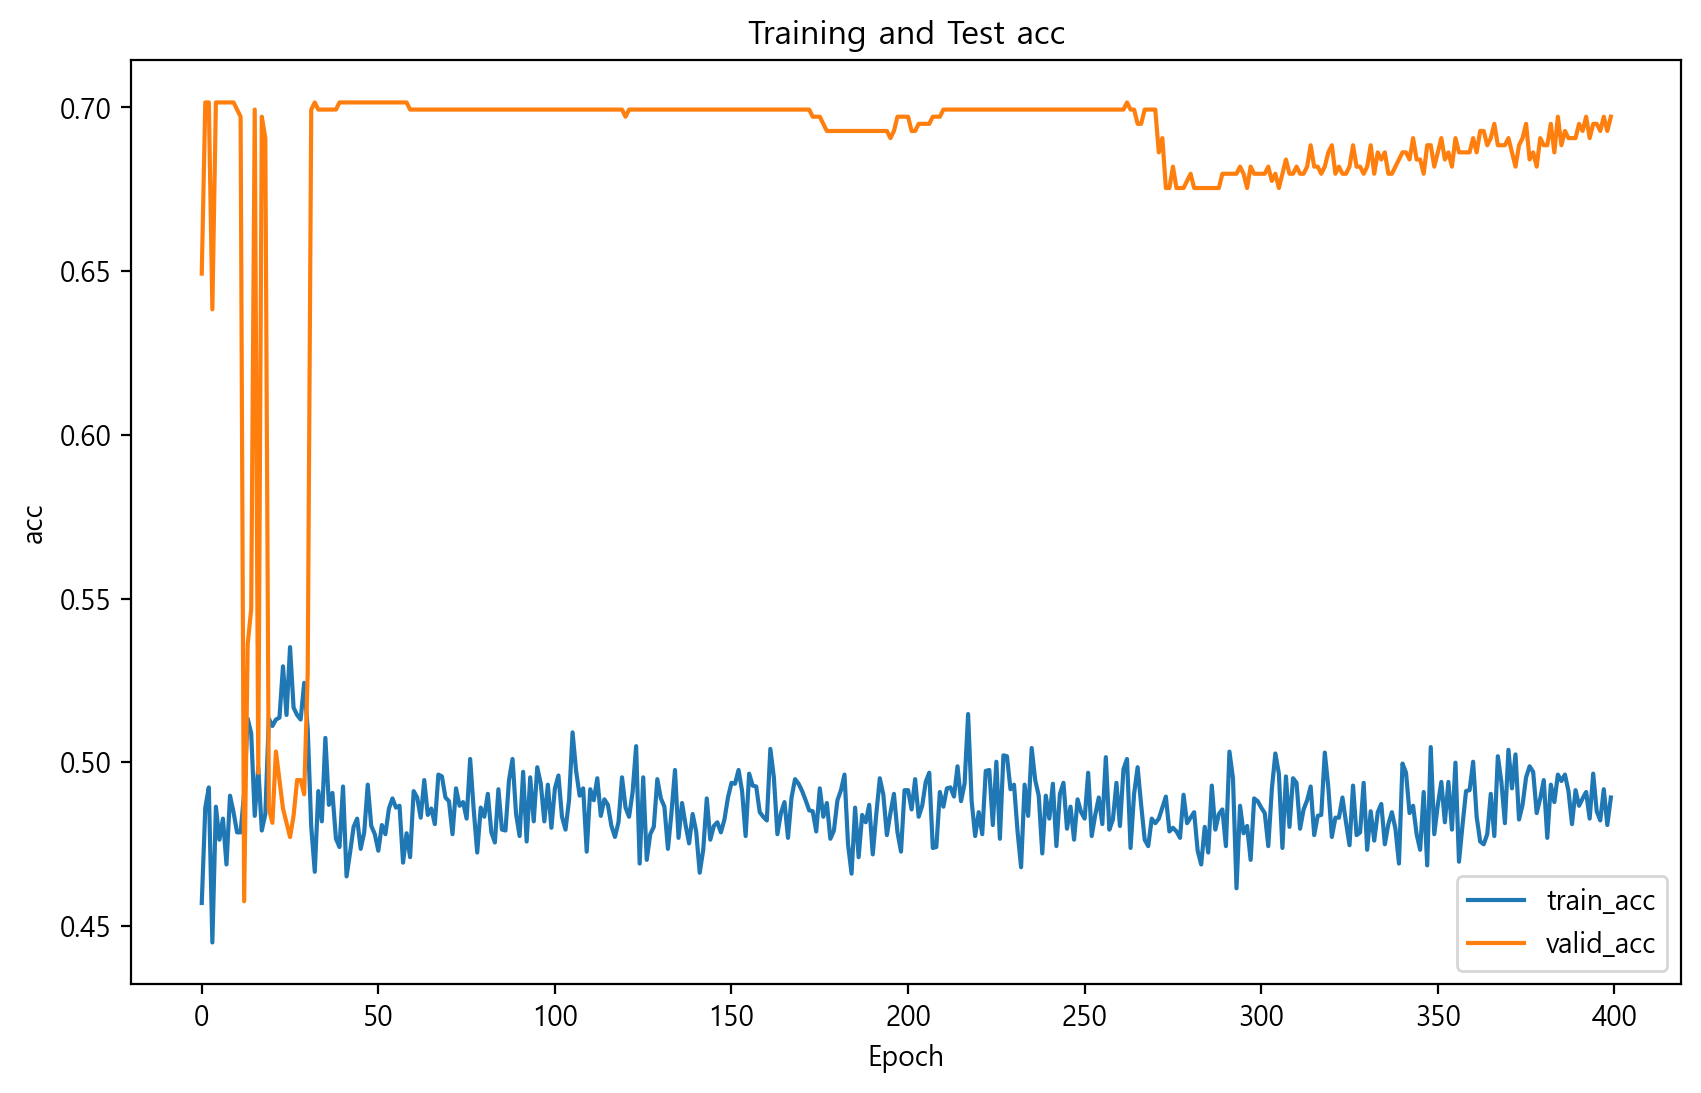

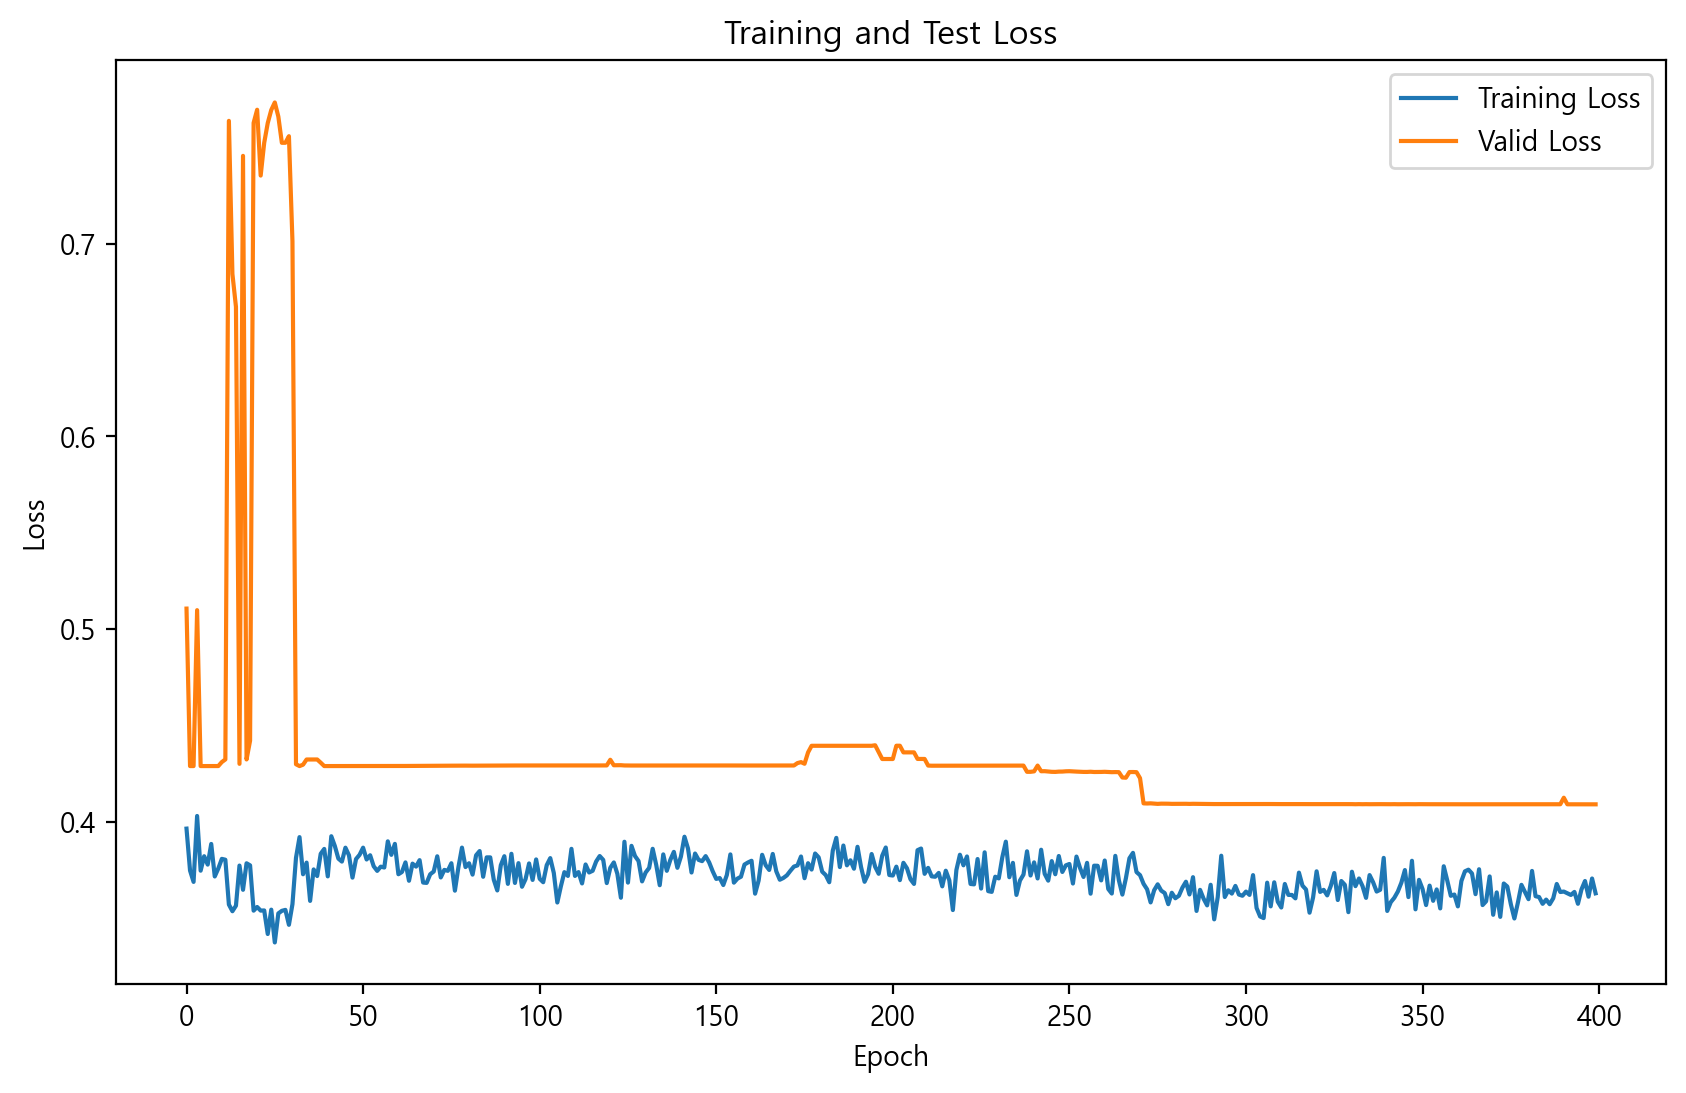

In [35]:
epoch = 400

train_losses, test_losses, train_acces, test_acces = train_test(model, criterion, optimizer, train_dataloader, validation_dataloader, epoch)
plot_acc(train_acces, test_acces)
plot_loss(train_losses, test_losses)

### NNs, Text Embedding 관련
https://www.youtube.com/watch?v=Fuw0wv3X-0o